In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.io
import shutil
import tarfile
import csv
import sys
import os

from sklearn.model_selection import train_test_split

## Data loading

In [ ]:
DATA_PATH = 'flower_dataset/'
PATH = "working/flower/"

def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

df = pd.DataFrame()
df['Id'] = sorted(get_all_filenames(DATA_PATH+"102flowers.tgz"))
df['Category'] = scipy.io.loadmat(DATA_PATH+'imagelabels.mat')['labels'][0] - 1  # классы (0, 1, 2, ...)
df['Category'] = df['Category'].astype(str)

In [ ]:
df.head()

,Id,Category
0,jpg/image_00001.jpg,76
1,jpg/image_00002.jpg,76
2,jpg/image_00003.jpg,76
3,jpg/image_00004.jpg,76
4,jpg/image_00005.jpg,76


In [ ]:
df['Category'].nunique()

102

In [ ]:
# Will unzip the files so that you can see them..
opened_tar = tarfile.open(DATA_PATH+"102flowers.tgz")
opened_tar.extractall(PATH)

print(os.listdir(PATH+'jpg')[:5])

['image_06393.jpg', 'image_05127.jpg', 'image_04692.jpg', 'image_06632.jpg', 'image_07912.jpg']


In [ ]:
# переложим данные в новую структуру - распределим картинки по папкам с наименованием класса
FINAL_PATH = 'flowers/'

if not os.path.exists(FINAL_PATH):
    os.makedirs(FINAL_PATH)

for row in df.itertuples():
    file_ = row.Id
    class_ = row.Category
    new_folder_name = f'class_{class_}'

    try:
      os.mkdir(os.path.join(FINAL_PATH, new_folder_name))
    except FileExistsError:
      print(f"Папка '{new_folder_name}' уже существует.")

    shutil.move(os.path.join(PATH, file_), os.path.join(FINAL_PATH, new_folder_name))


Выходные данные были обрезаны до нескольких последних строк (5000).
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'class_10' уже существует.
Папка 'c

In [ ]:
import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
%matplotlib inline

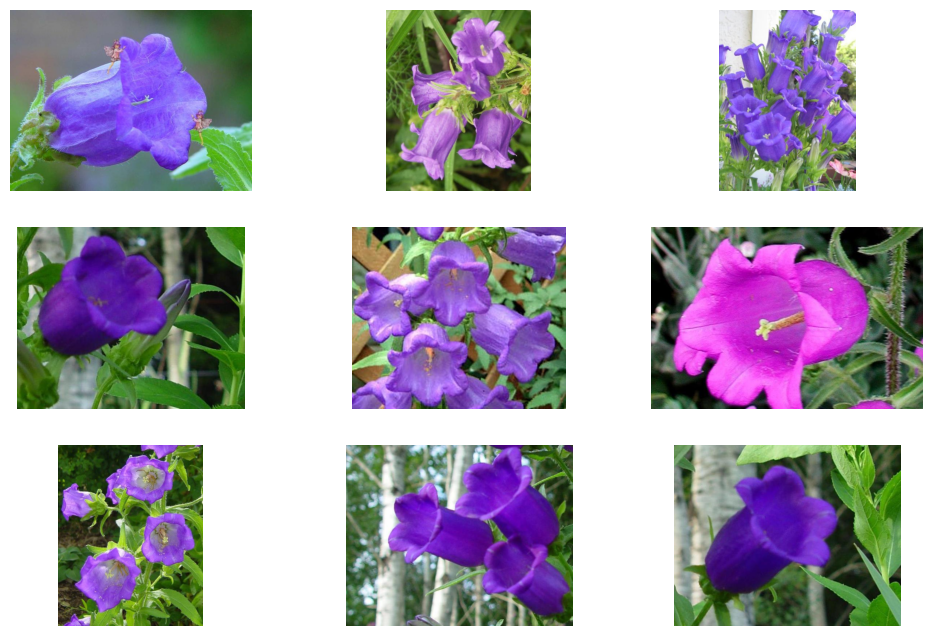

In [ ]:
# Image examples for one class
plt.figure(figsize=(12,8))

random_image_paths = os.path.join(FINAL_PATH, 'class_2')
random_image_paths = [os.path.join('class_2', file) for file in os.listdir(random_image_paths)]

for index, path in enumerate(random_image_paths[:9]):
    im = PIL.Image.open(FINAL_PATH+path)
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.axis('off')
plt.show()

## Train and Test

In [ ]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [ ]:
# добавим блок преобразования изображения в нужный формат
transform = transforms.Compose([
    # приводим к одному размеру
    transforms.Resize((224, 224)),
    # преобразуем в тензор
    transforms.ToTensor(),
    # используем стандартную нормализацию данных для датасетов типа ImageNet
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [ ]:
# считываем датасет
dataset = datasets.ImageFolder('flowers', transform=transform)

In [ ]:
# определяем размер выборок
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
print(train_size, test_size)

6551 1638


In [ ]:
# создаем треин тест
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:
# batch_size можно увеличивать в зависимости от возможности доступной GPU
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=32,
                                               shuffle=True,
                                               num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=32,
                                               shuffle=True,
                                               num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Simple CNN - урок 5

In [ ]:
# определяем архитектуру сверточной сети
class CNN(nn.Module):
    def __init__(self, input_shape, class_num):
        super(CNN, self).__init__()

        # Слой свертки 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape[0], 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        # Слой пулинга 1
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(p=0.2)

        # Слой свертки 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )

        # Слой пулинга 2
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(p=0.25)

        # Слой свертки 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )

        # Слой пулинга 3
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout(p=0.25)

        # Слой выравнивания и полносвязные слои
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * (input_shape[1] // 8) * (input_shape[2] // 8), 512)
        self.relu = nn.ReLU()
        self.dropout4 = nn.Dropout(p=0.25)
        self.fc2 = nn.Linear(512, class_num)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout4(x)
        x = self.fc2(x)

        return x

In [ ]:
# инициализируем модель на доступных ресурсах
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN((3, 224, 224), 102).to(device)

In [ ]:
def train(model, epochs, lr=0.001, print_during_epoch=True):
    # Optimizer and loss function

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    # Training model
    data_size = len(train_dataset)
    losses = []

    for epoch in range(epochs):
        examples_processed = 0
        current = 0
        correct_pred = 0

        for batch, target in train_dataloader:
            X, y = batch.to(device), target.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            losses.append(loss)

            _ ,pred_labels = torch.max(out, axis=1)
            correct_pred += (pred_labels == y).sum().item()

            current += 1
            examples_processed += len(batch)
            if not (current % 10) and print_during_epoch:
                print(f"Epoch {epoch+1}: percentage: {100*examples_processed/data_size:.2f}% | loss: {loss:.2f} | accuracy: {100*correct_pred/examples_processed:.2f}%")

        print(f"Epoch {epoch+1} | Percentage: 100%", end='')
        print(f" | Accuracy: {100*correct_pred/examples_processed:.2f}%")

    return model, losses

In [ ]:
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"

In [ ]:
# import gc
# gc.collect()

27

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
# Обучение CNN
model_cnn, losses_cnn = train(model, lr=1e-3, epochs=3)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1: percentage: 4.88% | loss: 5.84 | accuracy: 3.44%
Epoch 1: percentage: 9.77% | loss: 12.42 | accuracy: 2.50%
Epoch 1: percentage: 14.65% | loss: 7.30 | accuracy: 2.81%
Epoch 1: percentage: 19.54% | loss: 6.35 | accuracy: 2.81%
Epoch 1: percentage: 24.42% | loss: 5.81 | accuracy: 3.12%
Epoch 1: percentage: 29.31% | loss: 6.29 | accuracy: 3.49%
Epoch 1: percentage: 34.19% | loss: 4.86 | accuracy: 3.39%
Epoch 1: percentage: 39.08% | loss: 5.01 | accuracy: 3.36%
Epoch 1: percentage: 43.96% | loss: 4.59 | accuracy: 3.40%
Epoch 1: percentage: 48.85% | loss: 4.87 | accuracy: 3.19%
Epoch 1: percentage: 53.73% | loss: 4.60 | accuracy: 3.15%
Epoch 1: percentage: 58.62% | loss: 4.82 | accuracy: 3.10%
Epoch 1: percentage: 63.50% | loss: 4.56 | accuracy: 3.12%
Epoch 1: percentage: 68.39% | loss: 4.57 | accuracy: 3.08%
Epoch 1: percentage: 73.27% | loss: 4.57 | accuracy: 3.10%
Epoch 1: percentage: 78.16% | loss: 4.59 | accuracy: 3.12%
Epoch 1: percentage: 83.04% | loss: 4.59 | accuracy: 3.16

In [ ]:
def plot_losses(losses):
    plt.figure(figsize=(12, 6))
    plt.plot(losses)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Loss during training")
    plt.show()

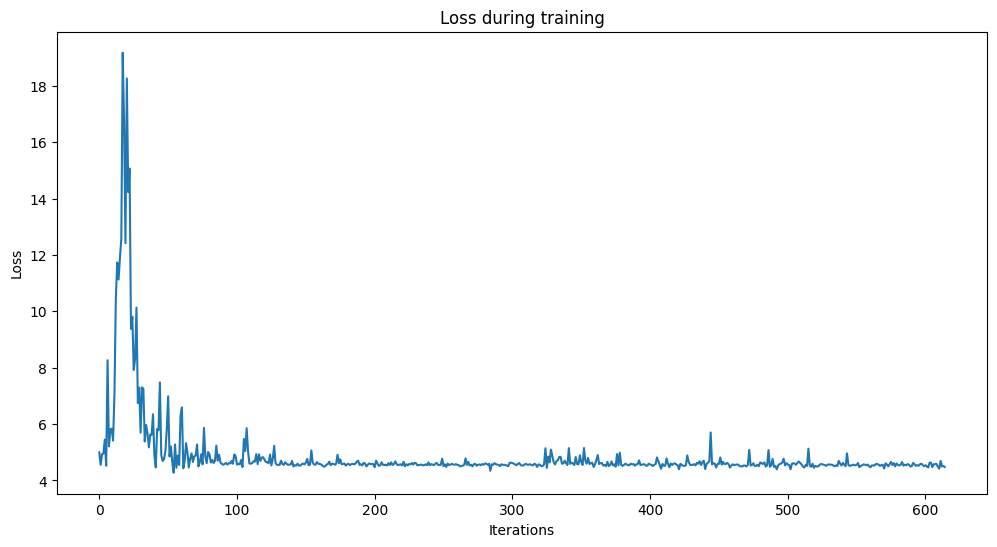

In [ ]:
# визуализируем лосс (при обучении гпу переносим вектора на cpu)
losses_cnn_cpu = [tensor.cpu().detach().numpy() for tensor in losses_cnn]
plot_losses(losses_cnn_cpu)

In [ ]:
# torch.save(model_cnn.state_dict(), 'my_model.pth')

## ResNet pretrained (урок 6)

In [ ]:
# batch_size можно увеличивать в зависимости от возможности доступной GPU - попробуйте увеличить batch_size
# и увидите кратное увеличение в accuracy уже на первой эпохе
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=64,
                                               shuffle=True,
                                               num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=64,
                                               shuffle=True,
                                               num_workers=4)

In [ ]:
# импортируем предобученный resnet
base_model = models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Посмотрим на архитектуру
print(base_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Размерность на входе в голову
num_ftrs = base_model.fc.in_features
# В нашем случае на выходе будет размерность 102 - меняем голову сети
# В общем случае мы можем это обощить до nn.Linear(num_ftrs, len(class_names)).
base_model.fc = nn.Linear(num_ftrs, 102)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_model = base_model.to(device)

In [ ]:
# Обучаем модель целиком
model_c, losses_c = train(custom_model, lr=1e-3, epochs=5)

Epoch 1: percentage: 9.77% | loss: 2.86 | accuracy: 30.31%
Epoch 1: percentage: 19.54% | loss: 1.88 | accuracy: 41.25%
Epoch 1: percentage: 29.31% | loss: 1.47 | accuracy: 48.07%
Epoch 1: percentage: 39.08% | loss: 0.84 | accuracy: 54.38%
Epoch 1: percentage: 48.85% | loss: 0.87 | accuracy: 58.84%
Epoch 1: percentage: 58.62% | loss: 0.99 | accuracy: 62.32%
Epoch 1: percentage: 68.39% | loss: 0.50 | accuracy: 65.20%
Epoch 1: percentage: 78.16% | loss: 0.59 | accuracy: 67.48%
Epoch 1: percentage: 87.93% | loss: 0.73 | accuracy: 68.99%
Epoch 1: percentage: 97.70% | loss: 0.75 | accuracy: 70.39%
Epoch 1 | Percentage: 100% | Accuracy: 70.49%
Epoch 2: percentage: 9.77% | loss: 0.40 | accuracy: 87.66%
Epoch 2: percentage: 19.54% | loss: 0.34 | accuracy: 87.89%
Epoch 2: percentage: 29.31% | loss: 0.39 | accuracy: 89.32%
Epoch 2: percentage: 39.08% | loss: 0.29 | accuracy: 89.96%
Epoch 2: percentage: 48.85% | loss: 0.27 | accuracy: 90.38%
Epoch 2: percentage: 58.62% | loss: 0.41 | accuracy: 90.

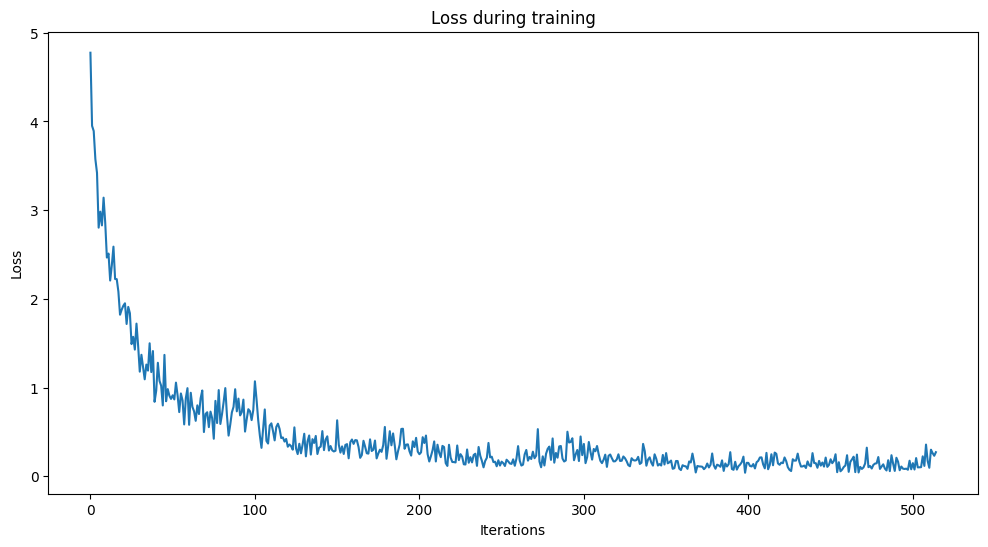

In [ ]:
losses_c_numpy = [tensor.cpu().detach().numpy() for tensor in losses_c]
plot_losses(losses_c_numpy)

In [ ]:
def evaluate_test_accuracy(model):
    test_dataset_size = len(test_dataset)
    correct_pred = 0
    for batch, target in test_dataloader:
        X, y = batch.to(device), target.to(device)
        out = model(X)

        _, pred_labels = torch.max(out, axis=1)
        correct_pred += (pred_labels == y).sum().item()

    print(f"Test accuracy: {100*correct_pred/test_dataset_size:.2f}%")

In [ ]:
# Точность на тесте
evaluate_test_accuracy(model_c)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test accuracy: 85.78%


In [ ]:
# Сейчас будем обучать не всю сеть целиком а только голову
model_freeze = models.resnet18(pretrained=True)

for param in model_freeze.parameters():
    param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s]


In [ ]:
# У только что созданных слоев параметр requires_grad=True по умолчанию
num_ftrs = model_freeze.fc.in_features
# Создаем новый последний слой
model_freeze.fc = nn.Linear(num_ftrs, 102)

In [ ]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_freeze = model_freeze.to(device)

In [ ]:
# Fine tuning предобученной сети
model_freeze, model_freeze_losses = train(model_freeze, lr=1e-3, epochs=5)

Epoch 1: percentage: 9.77% | loss: 4.37 | accuracy: 4.53%
Epoch 1: percentage: 19.54% | loss: 3.99 | accuracy: 7.03%
Epoch 1: percentage: 29.31% | loss: 3.52 | accuracy: 13.85%
Epoch 1: percentage: 39.08% | loss: 3.44 | accuracy: 18.28%
Epoch 1: percentage: 48.85% | loss: 3.13 | accuracy: 22.06%
Epoch 1: percentage: 58.62% | loss: 2.62 | accuracy: 26.12%
Epoch 1: percentage: 68.39% | loss: 2.21 | accuracy: 30.98%
Epoch 1: percentage: 78.16% | loss: 2.15 | accuracy: 34.43%
Epoch 1: percentage: 87.93% | loss: 2.02 | accuracy: 38.02%
Epoch 1: percentage: 97.70% | loss: 1.92 | accuracy: 41.27%
Epoch 1 | Percentage: 100% | Accuracy: 42.09%
Epoch 2: percentage: 9.77% | loss: 1.49 | accuracy: 80.31%
Epoch 2: percentage: 19.54% | loss: 1.47 | accuracy: 80.16%
Epoch 2: percentage: 29.31% | loss: 1.11 | accuracy: 80.89%
Epoch 2: percentage: 39.08% | loss: 1.22 | accuracy: 81.17%
Epoch 2: percentage: 48.85% | loss: 1.07 | accuracy: 81.31%
Epoch 2: percentage: 58.62% | loss: 0.98 | accuracy: 82.06

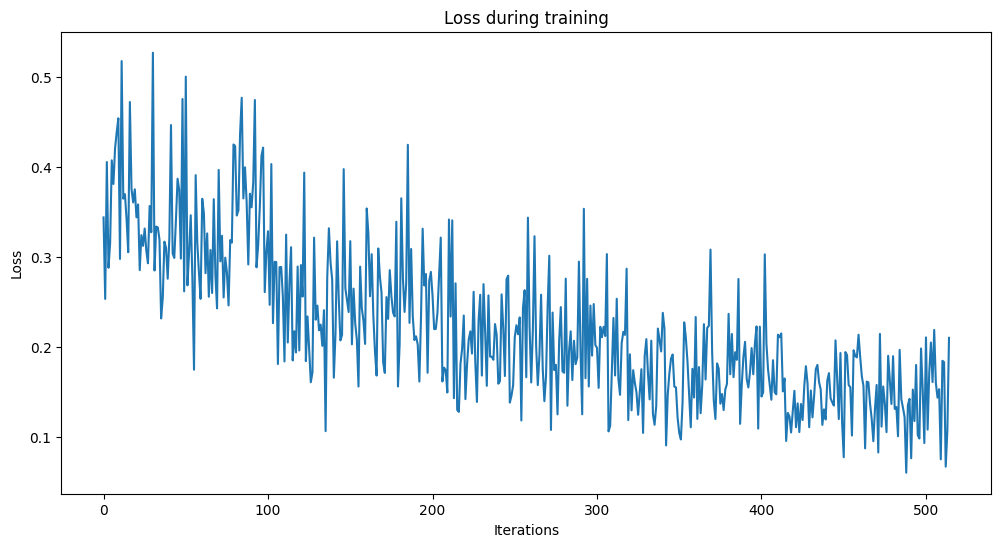

In [ ]:
model_freeze_losses = [tensor.cpu().detach().numpy() for tensor in model_freeze_losses]
plot_losses(model_freeze_losses)

In [ ]:
# точность на тесте
evaluate_test_accuracy(model_freeze)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test accuracy: 89.32%


In [ ]:
# сохраним результат
torch.save(model_freeze, 'model1.pth')

In [ ]:
# посмотрим какие слои обучались у нас в этой модели
for name, param in model_freeze.named_parameters():
    if param.requires_grad:
        print(f"Слой '{name}' будет обучаться.")

Слой 'fc.weight' будет обучаться.
Слой 'fc.bias' будет обучаться.


In [ ]:
# посмотрим какие слои обучались у нас в первой версии использования resnet
for name, param in base_model.named_parameters():
    if param.requires_grad:
        print(f"Слой '{name}' будет обучаться.")

Слой 'conv1.weight' будет обучаться.
Слой 'bn1.weight' будет обучаться.
Слой 'bn1.bias' будет обучаться.
Слой 'layer1.0.conv1.weight' будет обучаться.
Слой 'layer1.0.bn1.weight' будет обучаться.
Слой 'layer1.0.bn1.bias' будет обучаться.
Слой 'layer1.0.conv2.weight' будет обучаться.
Слой 'layer1.0.bn2.weight' будет обучаться.
Слой 'layer1.0.bn2.bias' будет обучаться.
Слой 'layer1.1.conv1.weight' будет обучаться.
Слой 'layer1.1.bn1.weight' будет обучаться.
Слой 'layer1.1.bn1.bias' будет обучаться.
Слой 'layer1.1.conv2.weight' будет обучаться.
Слой 'layer1.1.bn2.weight' будет обучаться.
Слой 'layer1.1.bn2.bias' будет обучаться.
Слой 'layer2.0.conv1.weight' будет обучаться.
Слой 'layer2.0.bn1.weight' будет обучаться.
Слой 'layer2.0.bn1.bias' будет обучаться.
Слой 'layer2.0.conv2.weight' будет обучаться.
Слой 'layer2.0.bn2.weight' будет обучаться.
Слой 'layer2.0.bn2.bias' будет обучаться.
Слой 'layer2.0.downsample.0.weight' будет обучаться.
Слой 'layer2.0.downsample.1.weight' будет обучатьс

In [ ]:
# попробуем заморозить только часть весов

In [ ]:
base_model = models.resnet18(pretrained=True)

base_model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
layers = list(base_model.named_parameters())
len(layers)

62

In [ ]:
# замораживаем первые 55 слоев, остальные будем учить
for name, param in layers[:55]:
    param.requires_grad = False

# У только что созданных слоев параметр requires_grad=True по умолчанию
num_ftrs = base_model.fc.in_features
# Создаем новый последний слой под нашу задачу
base_model.fc = nn.Linear(num_ftrs, 102)

In [ ]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = base_model.to(device)

# Fine tuning
base_model, base_model_losses = train(base_model, lr=1e-4, epochs=10)

Epoch 1: percentage: 9.77% | loss: 4.66 | accuracy: 1.09%
Epoch 1: percentage: 19.54% | loss: 4.48 | accuracy: 1.17%
Epoch 1: percentage: 29.31% | loss: 4.50 | accuracy: 1.82%
Epoch 1: percentage: 39.08% | loss: 4.42 | accuracy: 2.50%
Epoch 1: percentage: 48.85% | loss: 4.24 | accuracy: 3.00%
Epoch 1: percentage: 58.62% | loss: 4.46 | accuracy: 3.52%
Epoch 1: percentage: 68.39% | loss: 4.19 | accuracy: 3.95%
Epoch 1: percentage: 78.16% | loss: 4.12 | accuracy: 4.73%
Epoch 1: percentage: 87.93% | loss: 4.25 | accuracy: 5.35%
Epoch 1: percentage: 97.70% | loss: 4.14 | accuracy: 5.73%
Epoch 1 | Percentage: 100% | Accuracy: 5.89%
Epoch 2: percentage: 9.77% | loss: 3.95 | accuracy: 12.50%
Epoch 2: percentage: 19.54% | loss: 4.04 | accuracy: 13.05%
Epoch 2: percentage: 29.31% | loss: 3.95 | accuracy: 13.65%
Epoch 2: percentage: 39.08% | loss: 4.17 | accuracy: 13.91%
Epoch 2: percentage: 48.85% | loss: 3.73 | accuracy: 14.56%
Epoch 2: percentage: 58.62% | loss: 3.90 | accuracy: 15.23%
Epoch 2

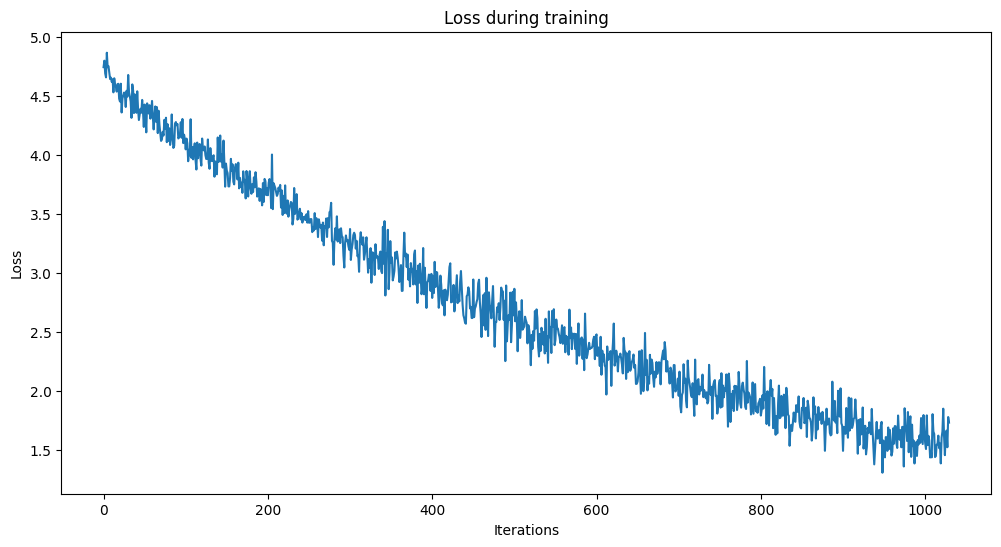

In [ ]:
# в данной реализации предобученной сети уменьшение замороженных весов не дает видимого результата
# для валидности эксперимента надо проверить на разных параметрах по количеству замороженных слоев
base_model_losses = [tensor.cpu().detach().numpy() for tensor in base_model_losses]
plot_losses(base_model_losses)

In [ ]:
# точность на тесте
evaluate_test_accuracy(base_model)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test accuracy: 77.59%


In [ ]:
# добавим в этап подготовки данных  аугментацию - в виде увеличения или уменьшения изображения
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomAffine(
        degrees=30,  # Не поворачивать
        scale=(0.8, 1.2),  # Масштабировать между 0.8 и 1.2
        shear=0,  # Не сдвигать
        translate=(0, 0)  # Не смещать
        ),
      transforms.Resize((224, 224)),  # Восстановить исходный размер
      transforms.ToTensor(),
      # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),

# на валидационном датасете оставим картинки без изменений
    'val': transforms.Compose([
      transforms.Resize((224, 224)),  # Восстановить исходный размер
      transforms.ToTensor(),
      # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# считываем датасет
dataset = datasets.ImageFolder('flowers')

# создаем треин тест
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataset.dataset.transform = data_transforms['train']
test_dataset.dataset.transform = data_transforms['val']

# batch_size можно увеличивать в зависимости от возможности доступной GPU
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=64,
                                               shuffle=True,
                                               num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=64,
                                               shuffle=True,
                                               num_workers=4)


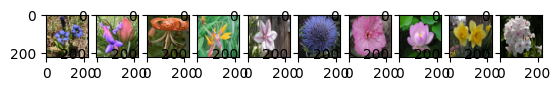

In [ ]:
# посмотрим на картинки
# for batch in train_dataloader:
#     images, labels = batch
#     break

# images, labels = images[:10], labels[:10]
# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.225])

# fig, axes = plt.subplots(nrows=1, ncols=len(images))
# for i, (image, ax) in enumerate(zip(images, axes)):
#     image_array = (image.permute(1, 2, 0).numpy() * std) + mean
#     image_array = np.clip(image_array, 0, 1)
#     ax.imshow(image_array)
# plt.show()

In [ ]:
model_new, model_freeze_losses = train(model_freeze, lr=1e-3, epochs=5)

Epoch 1: percentage: 9.77% | loss: 4.45 | accuracy: 2.19%
Epoch 1: percentage: 19.54% | loss: 3.84 | accuracy: 5.55%
Epoch 1: percentage: 29.31% | loss: 3.48 | accuracy: 10.36%
Epoch 1: percentage: 39.08% | loss: 3.13 | accuracy: 14.96%
Epoch 1: percentage: 48.85% | loss: 2.90 | accuracy: 19.88%
Epoch 1: percentage: 58.62% | loss: 2.58 | accuracy: 24.56%
Epoch 1: percentage: 68.39% | loss: 2.37 | accuracy: 28.68%
Epoch 1: percentage: 78.16% | loss: 1.98 | accuracy: 32.62%
Epoch 1: percentage: 87.93% | loss: 2.09 | accuracy: 36.63%
Epoch 1: percentage: 97.70% | loss: 1.90 | accuracy: 39.62%
Epoch 1 | Percentage: 100% | Accuracy: 40.38%
Epoch 2: percentage: 9.77% | loss: 1.49 | accuracy: 74.69%
Epoch 2: percentage: 19.54% | loss: 1.63 | accuracy: 78.52%
Epoch 2: percentage: 29.31% | loss: 1.11 | accuracy: 79.43%
Epoch 2: percentage: 39.08% | loss: 1.04 | accuracy: 79.88%
Epoch 2: percentage: 48.85% | loss: 1.28 | accuracy: 80.50%
Epoch 2: percentage: 58.62% | loss: 1.12 | accuracy: 81.28

In [ ]:
model = torch.load('model/model1.pth', weights_only=False)
model.eval()

In [ ]:
# точность на тесте
evaluate_test_accuracy(model_new)

Test accuracy: 88.46%


## OpenClip & TTA

In [ ]:
!pip install open-clip-torch

In [ ]:
import open_clip
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_image_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_text_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_basic_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_s13m_b4k'),
 ('ViT-

In [ ]:
!pip install ttach

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


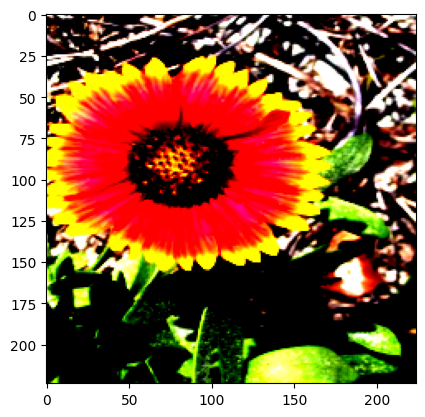

In [ ]:
# берем одну картинку из тестового сета
for batch in test_dataloader:
    images, labels = batch
    image = images[0]  # Извлечение одной картинки из пакета
    break

# Визуализация изображения
image_array = image.permute(1, 2, 0).numpy()
plt.imshow(image_array)
plt.show()

In [ ]:
# получаем предикт для этой картинки без TTA
out = model(images)
_, pred_labels = torch.max(out, axis=1)
print(pred_labels[0])

tensor(101)


In [ ]:
# применяем TTA
# полный список доступных преобразований описан тут https://github.com/qubvel/ttach
import ttach as tta

tta_model = tta.ClassificationTTAWrapper(model_freeze, tta.aliases.d4_transform(), merge_mode='mean')

with torch.no_grad():
    augmented_image = images
    prediction = tta_model(augmented_image)
    _, pred_labels = torch.max(out, axis=1)

In [ ]:
# predict
pred_labels[0]

tensor(101)